In [110]:
from dotenv import load_dotenv
load_dotenv()
from langchain_groq import ChatGroq
from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_ollama import ChatOllama

llm= ChatGroq(model='mistral-8x7b-32768')#  llama-3.1-8b-instant
llm= ChatGroq(model='llama-3.1-8b-instant')  
#llm = ChatGoogleGenerativeAI(model='gemini-1.5-flash-8b')
#llm = ChatOllama(model='wizardlm2:7b')


In [111]:
from unittest import result
from typing_extensions import Literal, TypedDict
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage

class Route(BaseModel):
    step: Literal['poem','story','joke']=Field(description='the next step in the routing process')

# Augment the LLM with schema for structured output
router = llm.with_structured_output(Route)


# state class
class State(TypedDict):
    input:str
    decision:str
    output:str


# nodes
def llm_call_1(state):
    """Write a story"""
    result = llm.invoke(state['input'])
    return {'output':result.content}

def llm_call_3(state):
    """Write a poem"""
    result = llm.invoke(state['input'])
    return {'output':result.content}

def llm_call_2(state):
    """Write a joke"""
    result = llm.invoke(state['input'])
    return {'output':result.content}


def llm_call_router(state):
    """Route the input to the appropriate node"""

    decision = router.invoke(
        [
            SystemMessage(
                content='Route the input to story, joke or poem based on the users request in few sentences'
            ),
            HumanMessage(
                content=state['input']
            )
        ]
    )
    return {'decision':decision.step}


# conditional edge function to route to the appropriate node
def route_decision(state):
    """Route the input to the appropriate node"""
    return state['decision']


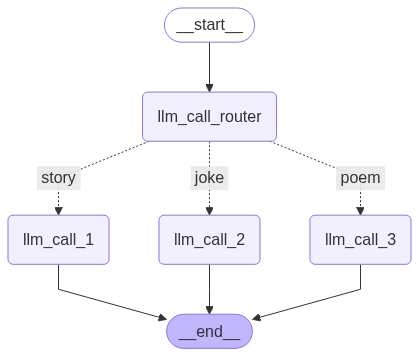

In [112]:
from langgraph.graph import StateGraph, START,END
from IPython.display import Image, display

graph = StateGraph(State)

graph.add_node('llm_call_router',llm_call_router)
graph.add_node('llm_call_1',llm_call_1)
graph.add_node('llm_call_2',llm_call_2)
graph.add_node('llm_call_3',llm_call_3)
graph.add_edge(START,'llm_call_router')

graph.add_conditional_edges(
    'llm_call_router',
    route_decision,
    {
        'story': 'llm_call_1',
        'joke': 'llm_call_2',
        'poem': 'llm_call_3',
    }
)
graph.add_edge('llm_call_1',END)
graph.add_edge('llm_call_2',END)
graph.add_edge('llm_call_3',END)

graph = graph.compile()

display(Image(graph.get_graph().draw_mermaid_png()))



In [113]:
state = graph.invoke({
    "input": "Write a joke about a robot learning to love"
})

In [114]:
state

{'input': 'Write a joke about a robot learning to love',
 'decision': 'joke',
 'output': "Why did the robot go on a dating app to learn to love?\n\nBecause it was looking for a 'charged' connection and wanted to 'reboot' its heart."}